In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.gridspec import GridSpec
from lmfit.models import GaussianModel
from scipy import optimize as optim

import sys
sys.path.append('Library/')

import drop_detection_tools as ddt


from tqdm import tqdm
%matplotlib inline

In [2]:
matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

<Figure size 432x288 with 0 Axes>

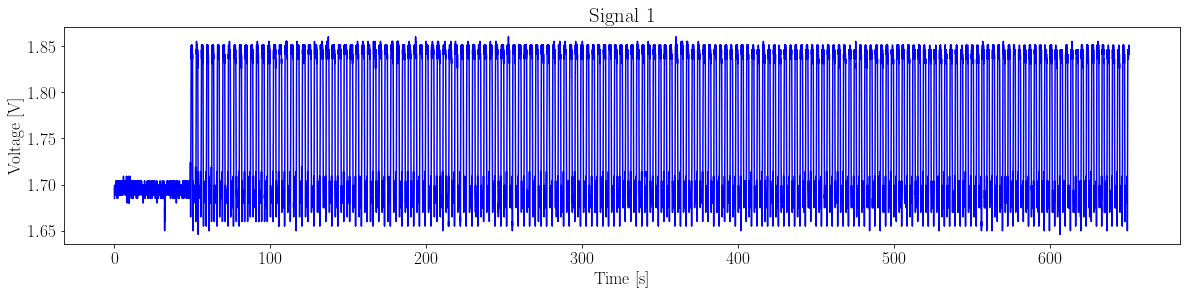

<Figure size 432x288 with 0 Axes>

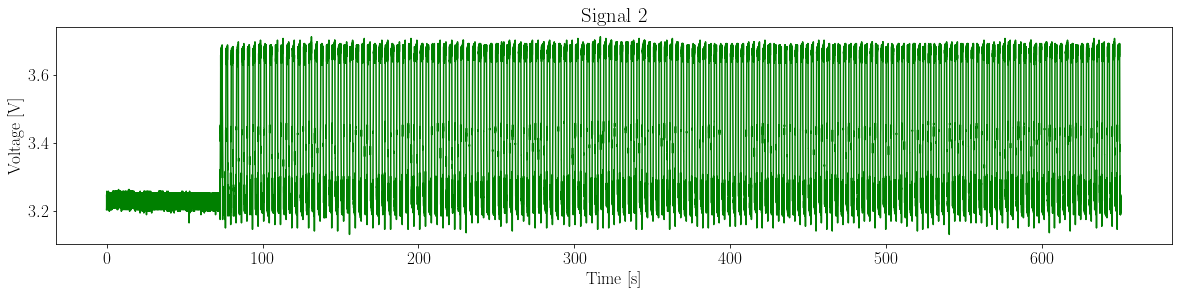

In [4]:
#************************************
folder   = '../../T-data/2-12/'
filename = 'B-ol5-aq5-pause10.csv'
name = '2-12_B-ol5-aq5'
#************************************

raw = True


sig1, sig2, t = ddt.read_LV(folder, filename)

### Resample data

Text(0.5, 1.0, 'Signal 2')

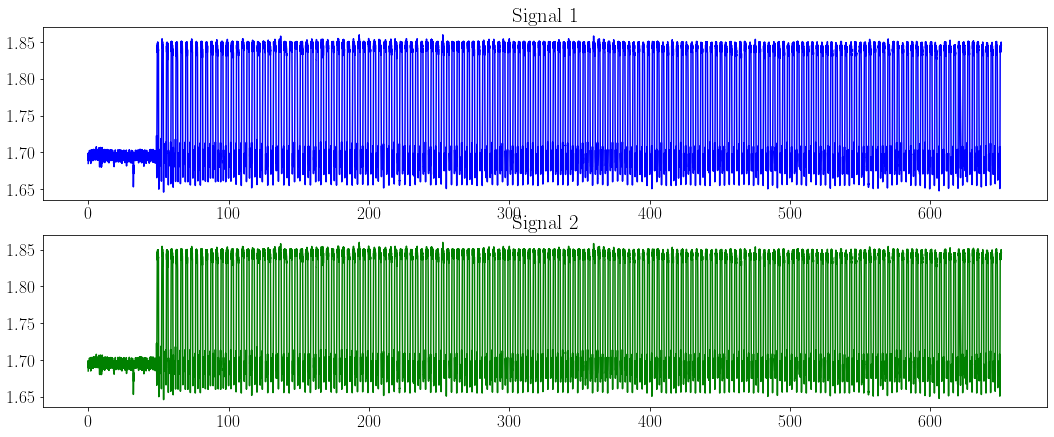

In [5]:
dt = 0.01 # sampling time

if raw:
    sig1, new_t = ddt.resample(sig1, t, dt=dt)
    sig2, _ = ddt.resample(sig2, t, dt=dt)
    t = new_t
    raw = False
else:
    print('data already resampled')


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18,7))

axs[0].plot(t, sig1, color='blue')
axs[0].set_title('Signal 1')

axs[1].plot(t, sig1, color='green')
axs[1].set_title('Signal 2')


## Fourier transformation


In [6]:
min_freq  = 1       # lower cut-off frequency
max_freq  = 10000   # higher cut-off frequency

### Signal 1 

C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


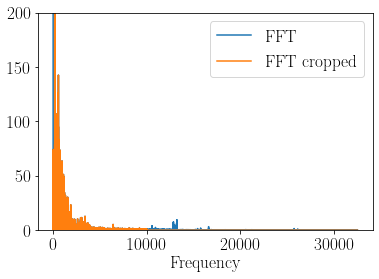

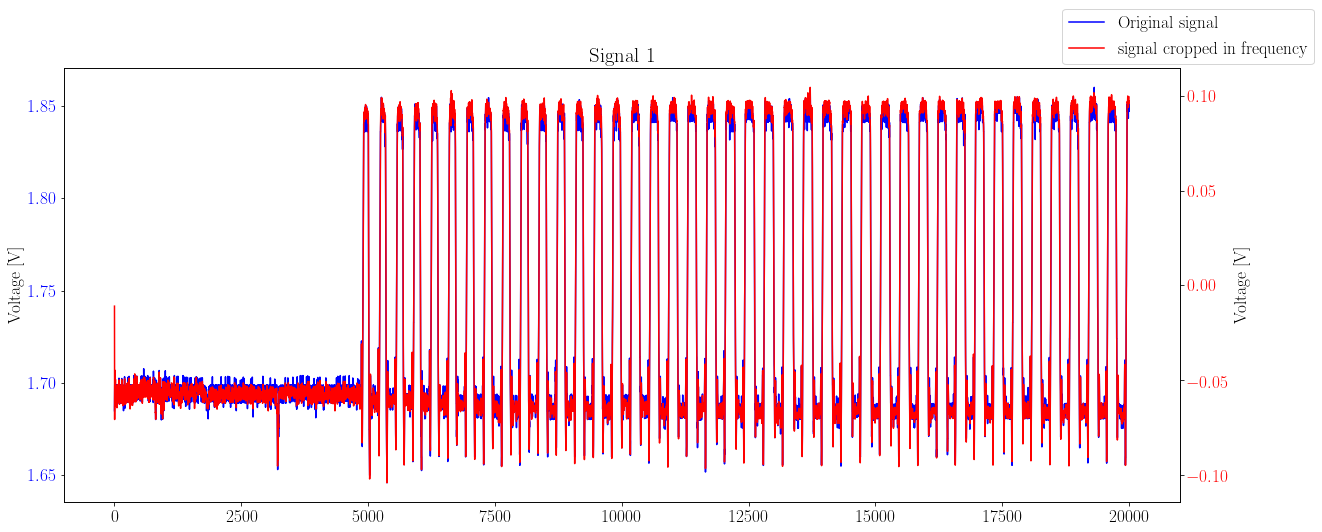

In [7]:
# FFT transform filtering
sig1_high = ddt.FFT_cropping(sig1, min_freq, max_freq)

x_min = 0       # signal plot x min.
x_max = 20000   # signal plot x max.
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

# Signal plot
color = 'blue'
ax1.set_title('Signal 1')
ax1.set_xlabel('')
ax1.set_ylabel('Voltage [V]')
ax1.plot(sig1[x_min:x_max], color = color, label='Original signal')
ax1.tick_params(axis = 'y', labelcolor = color)

# Filtered signal plot
color = 'red'
ax2 = ax1.twinx()   
ax2.set_xlabel('')
ax2.set_ylabel('Voltage [V]')                     
ax2.plot(sig1_high[x_min:x_max], color = color, label='signal cropped in frequency')
ax2.tick_params(axis = 'y', labelcolor = color)
fig.legend()


### Signal 2 

C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


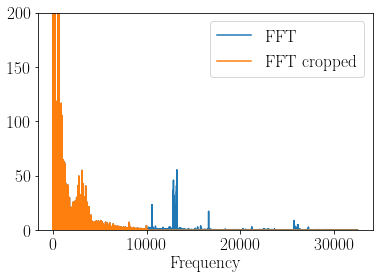

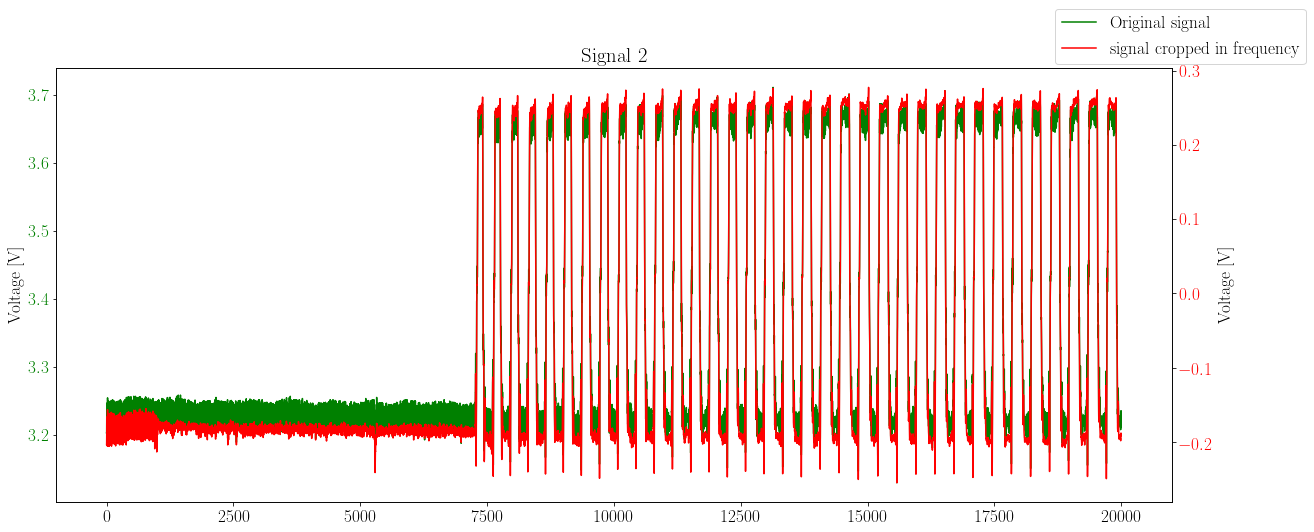

In [8]:
# FFT transform filtering
sig2_high = ddt.FFT_cropping(sig2, min_freq, max_freq)

x_min = 0    # Plot x min.
x_max = 20000  # Plot x max. 
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

# Signal plot
color = 'green'
ax1.set_title('Signal 2')
ax1.set_xlabel('')
ax1.set_ylabel('Voltage [V]')
ax1.plot(sig2[x_min:x_max], color = color, label='Original signal')
ax1.tick_params(axis = 'y', labelcolor= color)

# Filtered signal plot
color = 'red'
ax2 = ax1.twinx()                                 
ax2.set_ylabel('Voltage [V]')                     
ax2.plot(sig2_high[x_min:x_max], color = color, label='signal cropped in frequency')
ax2.tick_params(axis = 'y', labelcolor = color)
fig.legend()

## Thresholds computing

In [9]:
def thr_searcher(Data, nbins, color):
    
    # Histogram definition
    freq,bins,p = plt.hist(Data, nbins, color=color)
    x = 0.5 *(bins[:-1] + bins[1:])
    plt.clf() # Clear figure
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    #Cicle changing center1 position if condition (center1+2*sigma1 < center2-2*sigma2) is not fulfilled
    for i in range(1,6):    

        # Gaussian 1
        gauss1 = GaussianModel(prefix='g1_')
        pars   = gauss1.make_params(center=x[0]+i*(x[-1]-x[0])/10, sigma=(x[-1]-x[0])/15 , amplitude=max(freq)/20)
        
        # Gaussian 2
        gauss2 = GaussianModel(prefix='g2_')
        pars.update(gauss2.make_params())

        # Gaussian 1 parameters
        pars['g1_center'].set(max = x[0]+(x[-1]-x[0])*0.7, min=min(x))
        pars['g1_sigma'].set(max=(x[-1]-x[0])/10, min=(x[-1]-x[0])/30)
        #pars['g1_amplitude'].set(value=max(freq)/20,min=10)

        # Gaussian 2 parameters
        pars['g2_center'].set(value=x[-1]*0.98)
        pars['g2_sigma'].set(value=(x[-1]-x[0])/15)
        pars['g2_amplitude'].set(value=max(freq)/20, min=10)

        mod  = gauss1 + gauss2
        init = mod.eval(pars, x=x)
        out  = mod.fit(freq, pars, x=x)

        # Plot histo
        axes[0].hist(Data, nbins, color=color)
        axes[0].plot(x, out.init_fit, 'k--', label='initial fit')
        axes[0].plot(x, out.best_fit, 'r-', label='best fit')
        axes[0].legend(loc='best')
        axes[0].set_title("Signal histogram")
        axes[0].set_xlabel("Voltage [V]")
        axes[0].set_ylabel("Number of events") 

        # Searching the best fit
        center2 = out.best_values.get('g2_center')
        sigma2  = out.best_values.get('g2_sigma')
        center1 = out.best_values.get('g1_center')
        sigma1  = out.best_values.get('g1_sigma')

        if center1+2*sigma1 < center2-2*sigma2:
            max_freq1 = max(freq[x<center1+sigma1])
            x_max1    = x[np.argmax(freq[x<center1+2*sigma1])]
            max_freq2 = max(freq[x>center2-sigma2])
            a         = x > center2-sigma2
            freq2     = np.zeros(len(freq))
            for i in range(len(a)): 
                if a[i]==True: freq2[i]=freq[i]
            x_max2 = x[np.argmax(freq2)]
            break
        else: print('trying again')
     
    # Thresholds computing
    thr_low  = x_max1 + 3*sigma1
    thr_high = x_max2 - 3*sigma2
    print('thr_low  = ', thr_low,' \t[V] \nthr_high = ', thr_high, ' \t[V]')
    
    axes[0].vlines([thr_low, thr_high], *axes[0].get_ylim(), color='yellow')
    
    # Signal plot
    axes[1].plot(t, Data, color)
    axes[1].plot(thr_high*np.ones(len(t)), color='red')
    axes[1].plot(thr_low*np.ones(len(t)), color='red')
    plt.xlim((0,t[len(t)-1]))
    axes[1].set_title("Signal with thresholds")
    axes[1].set_xlabel("Time [s]")
    axes[1].set_ylabel("Voltage [V]") 
    
    return thr_low, thr_high

### Signal 1

In [ ]:
thr_low_1, thr_high_1 = thr_searcher(sig1_high, 200, color='blue')

In [ ]:
%matplotlib notebook
thr_low_1, thr_high_1 = ddt.thr_searcher(sig1_high[5000:], 500, high_sigmas=4, low_sigmas=3, Xdata=t[5000:],
                                         color='blue', xlabel='time [s]', ylabel='voltage [V]')

### Signal 2

In [ ]:
thr_low_2, thr_high_2 = thr_searcher(sig2_high, 50, color='green')

In [ ]:
thr_low_2, thr_high_2 = ddt.thr_searcher(sig2_high[8000:], 1000, high_sigmas=4, low_sigmas=8, Xdata=t[8000:],
                                         color='blue', xlabel='time [s]', ylabel='voltage [V]')

## Drops detection

In [ ]:
#new drop detection: narrow_start, narrow_end, wide_start, wide end

def drop_det_new(Xdata, Ydata, thr_low, thr_high, plot_switch=True, ymin=None, ymax=None, xrange=None, **kwargs):
    
    '''
    Description:
        Identifies the start and end position of the droplets in the narrow and wide range
    
    Params:
        - Xdata:             array with time (space)
        - Ydata:             array with the voltage/luminosity values
        - thr_low, thr_high: threshold computed with 'thr_seracher'
        - plot_switch:       if True shows plots
        - ymin, ymax:        ylims for the plot
        - xrange:            width of the window to be shown (expressed in time/space units)
        
    Returns:
        drop_start, drop_end: arrays with starts and ends of the droplets
                              They have always the same lenght and drop_start[0] < drop_end[0],
                              i.e. no spurious detections
    '''
    
    # Drops edges computing
    bool_high  = Ydata > thr_high
    bool_low   = Ydata < thr_low
    
    #first cycle finds narrow_start, drop_end are detected whe drop goes below thr_low, and we don't need them,
    #but they are necessary to the correct narrow_start detection
    #narrow_start is what we previously called drop_start, drop_end is the old drop_end
    narrow_start = [0]
    drop_end   = [1]
   
    for i in range(len(Ydata)-1):
        
        if bool_high[i]==False and bool_low[i+1]==False and bool_high[i+1]==True:
            if narrow_start[-1] < drop_end[-1] and i > drop_end[-1]:
                narrow_start.append(i)
                
        elif bool_low[i]==False and bool_low[i+1]==True and bool_high[i+1]==False:
            if narrow_start[-1] > drop_end[-1] and i > narrow_start[-1]:
                drop_end.append(i)
                
    #second cycle finds narrow_end. Now we call ascent_start the point where the drop goes beyond thr_low.
    ascent_start=[0]
    narrow_end=[1]
    
    for i in range(len(Ydata)-1):
        
        if bool_low[i]==True and bool_high[i]==False and bool_low[i+1]==False:
            if ascent_start[-1] < narrow_end[-1] and i > narrow_end[-1]:
                ascent_start.append(i)
                
        elif bool_low[i]==False and bool_high[i]==True and bool_high[i+1]==False  :
            if i > ascent_start[-1]:
                if ascent_start[-1] > narrow_end[-1]:
                    narrow_end.append(i)
                else: 
                    narrow_end[-1]=i      #make sure to take the real narrow_end, not just a fluctuation in the middle of the drop
                
                
    # Selection
    narrow_start = narrow_start[1:]
    narrow_end   = narrow_end[1:]
    ascent_start = ascent_start[1:]
    drop_end     = drop_end[1:] 
    # Cropping
    if len(narrow_start) > len(narrow_end):
        narrow_start = narrow_start[:-1] 
    print(len(narrow_start), len(narrow_end))
                
    #find wide_start and wide_end. Only need low thr:
    #check whenever signal simply overcomes low threshold and stores those indices
    # wide start: last spike that goes beyond low threshold before ascent_start
    # wide_end: first spike to go below low threshold after drop_end
    
    spike_start=[]
    spike_end=[]
    wide_start=[]
    wide_end=[]
    
    for i in range(len(Ydata)-1):
        if bool_low[i]==True and bool_low[i+1]==False:
            spike_start.append(i)
        elif bool_low[i]==False and bool_low[i+1]==True:
            spike_end.append(i)
            
    spike_start = np.array(spike_start)
    spike_end = np.array(spike_end)
    
    b=0    
    for start,end in list(zip(narrow_start,narrow_end)):
        #print(start,end)
        a = spike_start[spike_start<start][-2]        
        wide_start.append(a)
        if b>a: print(t[start],'s: LOWER THRESHOLD TOO LOW')
        if len(spike_end[spike_end>end])>1:
            b = spike_end[spike_end>end][1]
            wide_end.append(b)
        
    #cropping
    if len(wide_start) > len(wide_end):
        wide_start = wide_start[:-1] 
    if len(narrow_start)>len(wide_start):
        narrow_start = narrow_start[:-1] 
        narrow_end = narrow_end[:-1] 
        
    print(len(narrow_start), len(narrow_end))
    
    # Number acquisition -> time [s] conversion
    narrow_start = Xdata[narrow_start]
    narrow_end   = Xdata[narrow_end]
    wide_start   = Xdata[wide_start]
    wide_end     = Xdata[wide_end]
    
    # Plotting 
    if plot_switch:
        if xrange is None:
            xrange = Xdata[-1]
        for j in range(int (Xdata[-1]/xrange)):
            fig, ax = plt.subplots(figsize=(20,4))
            plt.plot(Xdata, Ydata, **kwargs)
            
            if ymin is None or ymax is None:
                ymin, ymax = ax.get_ylim()
            else:
                plt.ylim(ymin, ymax)
            
            for i in range(len(narrow_end)):

                plt.vlines(narrow_start[i], ymin, ymax, color='green')
                plt.vlines(narrow_end[i],   ymin, ymax, color='red')
                plt.vlines(wide_start[i],ymin, ymax, color='lime')
                plt.vlines(wide_end[i],ymin, ymax, color='orange')

            plt.ylabel("Luminosity")
            plt.xlabel("Position [mm]")
            plt.xlim(j*xrange,(j+1)*xrange)
            plt.plot(thr_high*np.ones(len(Xdata)), color='yellow')
            plt.plot(thr_low *np.ones(len(Xdata)), color='cyan')
            plt.show()
            
            
            
            
    
    
    
    
        
    return np.array(narrow_start), np.array(narrow_end), np.array(wide_start), np.array(wide_end)

### Signal 1

In [ ]:
xrange       =    100    # single plot x range [s]
narrow_start_1, narrow_end_1, wide_start_1, wide_end_1 = drop_det_new(t, sig1_high, thr_low_1, thr_high_1,
                                                                        xrange=xrange, plot_switch=True)

### Signal 2

In [ ]:
xrange       = 100           # single plot x range [s]
narrow_start_2, narrow_end_2, wide_start_2, wide_end_2= drop_det_new(t, sig2_high, thr_low_2, thr_high_2,
                                                                        xrange=xrange, plot_switch=True)


## Slope function

In [ ]:
def slope_det(Xdata, Ydata, thr_low, thr_high, plot_switch=True, ymin=None, ymax=None, xrange=None, **kwargs):
    
    '''
    Description:
        If drop_start identifies the end of the ascent of the signal and drop_end the end of the descent of the signal,
        drop_ascent identifies the start of the ascent of the signal and drop_descent the atart of the descent of the signal.
        So using both start-end and ascent-descent, we can estimate the slope of drop signal.
    
    Params:
        - Xdata:             array with time (space)
        - Ydata:             array with the voltage/luminosity values
        - thr_low, thr_high: threshold computed with 'thr_seracher'
        - plot_switch:       if True shows plots
        - ymin, ymax:        ylims for the plot
        - xrange:            width of the window to be shown (expressed in time/space units)
        
    Returns:
        drop_ascent, drop_descent: arrays with starts and ends of the droplets
                              They have always the same lenght and drop_ascent[0] < drop_descent[0],
                              i.e. no spurious detections
    '''
    
    # Drops edges computing
    bool_high  = Ydata > thr_high
    bool_low   = Ydata < thr_low
    drop_ascent = [0]
    drop_descent   = [1]
    
    #if it's needed use range1 and range 2 as parameters
    range1=10
    range2=10
   
    # Detection
    for i in range(len(Ydata)-range1):
        
        if bool_low[i]==True and bool_high[i]==False and all(bool_low[i+1:i+1+range1]==[False for i in range(range1)]):
            if drop_ascent[-1] < drop_descent[-1] and i > drop_descent[-1]:
                drop_ascent.append(i-1)
                
        elif bool_low[i]==False and bool_high[i]==True and all(bool_high[i+1:i+1+range2]==[False for i in range(range2)]) :
            if drop_ascent[-1] > drop_descent[-1] and i > drop_ascent[-1]:
                drop_descent.append(i-1)
 
    # Number acquisition -> time [s] conversion
    drop_ascent = Xdata[drop_ascent]
    drop_descent   = Xdata[drop_descent]
    
    # Selection
    drop_ascent = drop_ascent[1:]
    drop_descent   = drop_descent[1:]
    
    # Cropping
    if len(drop_ascent) > len(drop_descent):
        drop_ascent = drop_ascent[:-1]
    
    # Plotting 
    if plot_switch:
        if xrange is None:
            xrange = Xdata[-1]
        for j in range(int (Xdata[-1]/xrange)):
            fig, ax = plt.subplots(figsize=(20,4))
            plt.plot(Xdata, Ydata, **kwargs)
            
            if ymin is None or ymax is None:
                ymin, ymax = ax.get_ylim()
            else:
                plt.ylim(ymin, ymax)
            
            for i in range(len(drop_descent)):

                plt.vlines(drop_ascent[i], ymin, ymax, color='green')
                plt.vlines(drop_descent[i],   ymin, ymax, color='red')

            plt.ylabel("Luminosity")
            plt.xlabel("Position [mm]")
            plt.xlim(j*xrange,(j+1)*xrange)
            plt.plot(thr_high*np.ones(len(Xdata)), color='yellow')
            plt.plot(thr_low *np.ones(len(Xdata)), color='cyan')
            plt.show()
            
                            
    return np.array(drop_ascent), np.array(drop_descent)

In [ ]:
%matplotlib notebook
xrange =500
drop_ascent_1, drop_descent_1 = slope_det(t, sig1_high, thr_low_1, thr_high_1, xrange=xrange, plot_switch=True)


In [ ]:
xrange =500
drop_ascent_2, drop_descent_2 = slope_det(t, sig2_high, thr_low_2, thr_high_2, xrange=xrange, plot_switch=True)

In [ ]:
#check consistency with drop_start
if len(drop_ascent_1) != len(drop_start_1):
    raise ValueError("DROP ASCENT AND DROP START ARE NOT CONSISTENT IN SIG 1")   
if len(drop_ascent_2) != len(drop_start_2):
    raise ValueError("DROP ASCENT AND DROP START ARE NOT CONSISTENT IN SIG 2")  
    
#if there are problems, in the function slope_det, in the cicle, we should try to implement a further condition of consistency 
#with drop_start and drop_end.

In [ ]:
ascent_t_1 = drop_start_1-drop_ascent_1
descent_t_1 = drop_descent_1-drop_end_1

ascent_t_2 = drop_start_2-drop_ascent_2
descent_t_2 = drop_descent_2-drop_end_2

In [ ]:
slope_ascent_1= (thr_high_1-thr_low_1)/ascent_t_1
slope_descent_1= (thr_high_1-thr_low_1)/descent_t_1

slope_ascent_2= (thr_high_2-thr_low_2)/ascent_t_2 
slope_descent_2= (thr_high_2-thr_low_2)/descent_t_2

In [ ]:
#time error on the ascent
#we must caluclate more properly the voltage error, here I used sigma_high
err_ascent_1 = sigma_high_1/slope_ascent_1
err_descent_1 = abs(sigma_high_1/slope_descent_1)
err_ascent_2 = sigma_high_2/slope_ascent_2
err_descent_2 = abs(sigma_high_2/slope_descent_2)

In [ ]:
drop_ascent_1[0],drop_start_1[0]

In [ ]:
slopes = []

for i, p in enumerate(t):
    if p<drop_ascent_1[0]:
        continue
    elif p>=drop_start_1[0]:
        break
    else:
        slopes.append((-sig1_high[i]+thr_high_1)/(drop_start_1[0]-p))
    
    


plt.figure()
plt.plot(slopes)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.plot(sig1_high[1:]-sig1_high[:-1])
ax2 = ax.twinx()
ax2.plot(sig1_high, alpha=0.5, color='red')

In [ ]:
plt.figure()
plt.hist(sig1_high[1:]-sig1_high[:-1], bins = 10000)
plt.xlim(-0.25,0.25)